In [1]:
import numpy as np
import  pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn.metrics import classification_report
from plot_keras_history import plot_history
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
%matplotlib notebook
%matplotlib inline

In [2]:
data=pd.read_csv('DATA.csv')

In [3]:
data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
data['label']=data['label'].replace(2,1)

In [5]:
X=data['combined_result']
y=data['label']
time_series=data['t_dist']

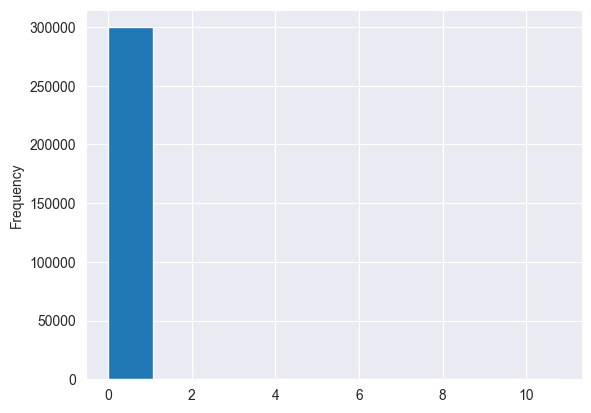

In [6]:
X.plot(kind='hist')
plt.show()

In [7]:
# Extracting sequences from the dataset
sequences=[]
labels=[]
temp=[]

for index,value in y.items():
    if value==1:
        temp.append(X[index])
        if (index+1)<len(y) and y[index+1]==0:
            sequences.append(temp)
            labels.append(1)
            temp=[]
    if value==0:
        temp.append(X[index])
        if (index+1)<len(y) and y[index+1]==1:
            sequences.append(temp)
            labels.append(0)
            temp=[]

In [8]:
unique_lengths = []  # Create an empty list to store unique lengths

for sublist in sequences:
    sublist_length = len(sublist)
    if sublist_length not in unique_lengths:
        unique_lengths.append(sublist_length)

unique_lengths.sort()  # Sort the unique lengths list

print("Unique sublist lengths:")
for length in unique_lengths:
    print(length)

total_unique_lengths = len(unique_lengths)
print("Total count of unique lengths:", total_unique_lengths)

# Calculate the median
if total_unique_lengths % 2 == 0:
    # If there is an even number of unique lengths, calculate the average of the middle two
    median = (unique_lengths[total_unique_lengths // 2 - 1] + unique_lengths[total_unique_lengths // 2]) / 2
else:
    # If there is an odd number of unique lengths, take the middle value
    median = unique_lengths[total_unique_lengths // 2]

print("Median sublist length:", median)


Unique sublist lengths:
16
18
20
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
106
111
112
114
116
118
120
122
124
128
130
131
132
134
142
144
146
152
153
156
157
158
161
163
166
167
178
182
183
184
186
187
191
194
197
205
211
212
219
222
224
225
227
230
236
238
240
246
249
251
256
263
267
268
269
270
273
274
275
276
280
282
292
294
295
297
300
303
304
309
310
312
316
319
320
326
327
328
330
335
336
343
346
348
349
351
352
360
361
365
366
367
372
374
378
381
385
390
392
396
397
398
399
402
403
408
409
410
413
426
427
428
430
432
433
436
440
447
451
460
466
477
480
496
500
502
517
530
547
551
557
560
570
572
585
599
601
611
649
670
702
724
746
751
Total count of unique lengths: 186
Median sublist length: 259.5


In [9]:
# Not a sequence but label is 1 
zero_seq_label_one=[]
for position, sublist in enumerate(sequences):
    if all(element == 0 for element in sublist):
        if labels[position]==1:
            zero_seq_label_one.append(position)

In [10]:
# Replacing those with 0
for value in zero_seq_label_one:
    labels[value]=0

In [11]:
# Is a sequence but label 0
seq_label_zero=[]
for position, sublist in enumerate(sequences):
    if any(element != 0 for element in sublist):
        if labels[position]==0:
            seq_label_zero.append(position)

In [12]:
# Replacing those with 1
for value in seq_label_zero:
    labels[value]=1

In [13]:
# Train test splitt
X_train,X_test,y_train,y_test=train_test_split(sequences,labels,test_size=0.2,random_state=42)

In [14]:
def one_step_attention(a,s_prev,repeator,concatenator,densor1,densor2,activator,dotor):
    # We done this to change s_prev to shape of(m,Tx,n_s) for cocatination with a, because concatenation requires all dimension same accept concat axis in this 
    # case is last one so a and s_prev have same first two dims (m,Tx) but last one is changed
    s_prev=repeator(s_prev)
    # We will here concatenate a and s_prev
    concat=concatenator([a,s_prev])
    # here i will calculate energies with 2 dense layers
    e=densor1(concat)
    energies=densor2(e)
    # we know alpha is softmax of this energy
    alpha=activator(energies)
    # to calculate context vector we take dot product of alpha and a
    context_vector=dotor([alpha,a])
    return context_vector

In [15]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.
post_activation_LSTM_cell = tf.keras.layers.LSTM(n_s, return_state = True) # Please do not modify this global variable.
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [16]:
def modelf(Tx,Ty,n_a, n_s,train,test):
    X=tf.keras.layers.Input(shape=(train.shape[1],1)) # because embedding layer only demands the sequence length if i give full shape like (m,Tx) the
    # ouput of embedding layer will be 4D which can not be fed into BILSTM
    # hidden state for post LSTM
    s0 = tf.keras.layers.Input(shape=(n_s,), name='s0')
    # cell state for post lstm
    # because we know From CampusX that shape of hidden and cell state of lstm are equal
    c0 = tf.keras.layers.Input(shape=(n_s,), name='c0')
    s=s0
    c=c0
    outputs = []

    a = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_a,return_sequences=True),input_shape=(train.shape[1],1))(X)
    repeator = tf.keras.layers.RepeatVector(Tx)
    concatenator = tf.keras.layers.Concatenate(axis=-1)
    densor1 =tf.keras.layers. Dense(10, activation = "tanh")
    densor2 = tf.keras.layers.Dense(1, activation = "relu")
    activator = tf.keras.layers.Activation('softmax', name='attention_weights') 
    dotor =tf.keras.layers. Dot(axes = 1)

    for t in range(Ty):
        context=one_step_attention(a,s,repeator=repeator,concatenator=concatenator,densor1=densor1,densor2=densor2,activator=activator,dotor=dotor)
        _,s,c=post_activation_LSTM_cell(context,initial_state = [s,c] )
        out = output_layer(s)
        outputs.append(out)



    print(outputs)
    model=tf.keras.models.Model(inputs=[X,s0,c0],outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001,beta_1=0.9,beta_2=0.999)#0.00001
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = opt, metrics = ['accuracy'])

    return model

In [17]:




def train_evaluate(train_data,train_y,test_data,test_y,Tx=0,Ty=1):
        # Label Reshaping
        train_label=np.array(train_y)
        test_label=np.array(test_y)
        train_label=train_label.reshape(-1,1)
        test_label=test_label.reshape(-1,1)
        # Padding and reshaping
        train = pad_sequences(train_data, padding='post', truncating='post', dtype=float, maxlen=Tx)
        test = pad_sequences(test_data, padding='post', truncating='post', dtype=float, maxlen=Tx)
        # Feature Reshaping
        train=train.reshape(train.shape[0], train.shape[1], 1)
        test=test.reshape(test.shape[0], test.shape[1], 1)
        # Model Calling
        model=modelf(Tx,Ty,n_a, n_s,train,test)
        early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min', verbose=1)
        
        history=model.fit(
            [train, np.zeros((train.shape[0],n_s)), np.zeros((train.shape[0],n_s))],
            train_label,
            callbacks=early_stopping,
            epochs=500,
            batch_size=100,
            verbose=2,
            validation_data=(
                [test, np.zeros((test.shape[0], n_s)), np.zeros((test.shape[0], n_s))],
                test_label)
        )
        
        return history


In [18]:
lengths = [value for value in range(50, 301, 50)]
results=[]
for value in lengths:
    print("The Result after",value,"Length value")
    results.append(train_evaluate(X_train,y_train,X_test,y_test,Tx=value))
    

The Result after 50 Length value
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>]
Epoch 1/500
12/12 - 17s - loss: 0.7038 - accuracy: 0.2235 - val_loss: 0.7041 - val_accuracy: 0.2552 - 17s/epoch - 1s/step
Epoch 2/500
12/12 - 1s - loss: 0.7025 - accuracy: 0.2899 - val_loss: 0.7028 - val_accuracy: 0.3276 - 1s/epoch - 108ms/step
Epoch 3/500
12/12 - 1s - loss: 0.7013 - accuracy: 0.3382 - val_loss: 0.7016 - val_accuracy: 0.3552 - 1s/epoch - 91ms/step
Epoch 4/500
12/12 - 1s - loss: 0.7001 - accuracy: 0.3762 - val_loss: 0.7003 - val_accuracy: 0.3759 - 1s/epoch - 108ms/step
Epoch 5/500
12/12 - 1s - loss: 0.6989 - accuracy: 0.4098 - val_loss: 0.6991 - val_accuracy: 0.4034 - 1s/epoch - 98ms/step
Epoch 6/500
12/12 - 1s - loss: 0.6978 - accuracy: 0.4340 - val_loss: 0.6979 - val_accuracy: 0.4172 - 1s/epoch - 94ms/step
Epoch 7/500
12/12 - 1s - loss: 0.6966 - accuracy: 0.4616 - val_loss: 0.6967 - val_accuracy: 0.4517 - 1s/epoch - 112ms/step
Epoch 8/500
12/12 - 1s - loss: 0.695

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

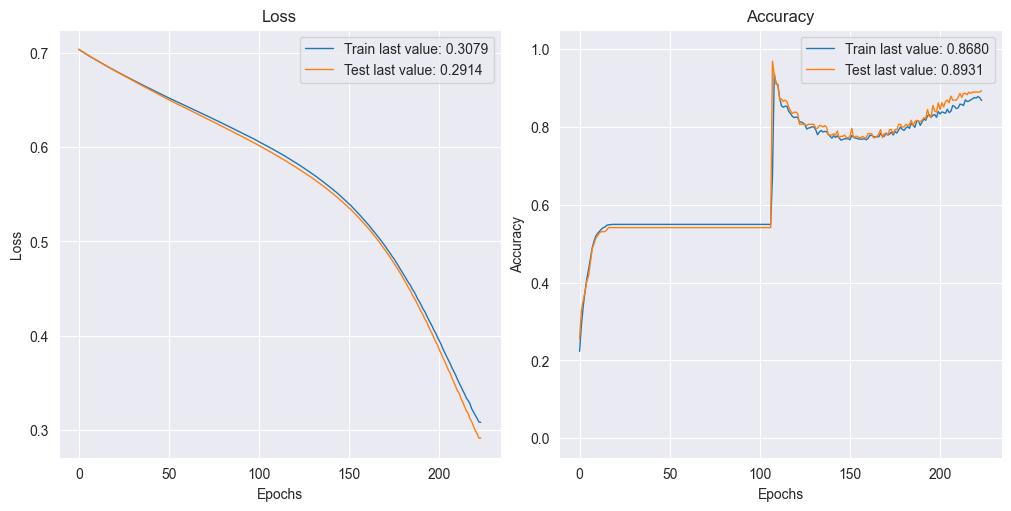

In [21]:
plot_history(results[0],show_standard_deviation=False,show_average=True)
# With Length of 50 

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

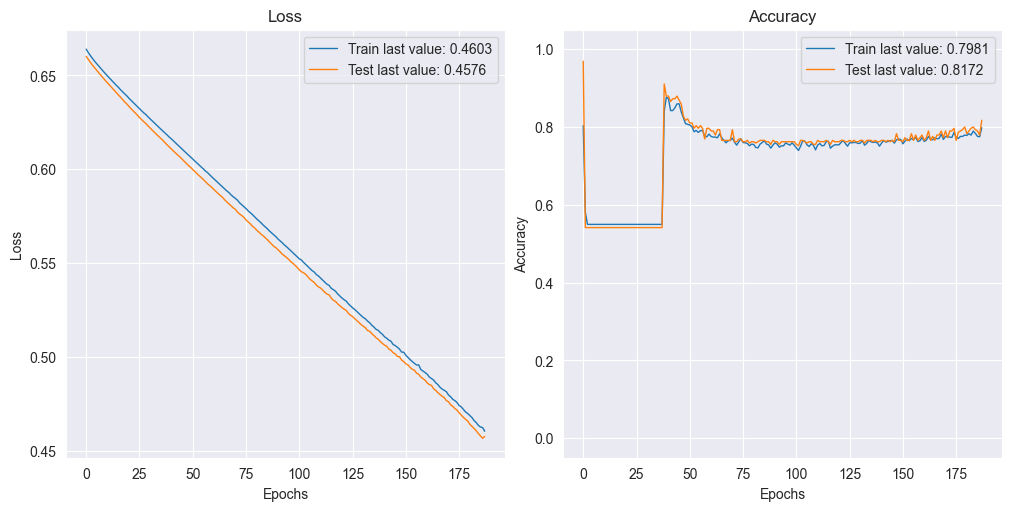

In [22]:
plot_history(results[1],show_standard_deviation=False,show_average=True)
# With Length 100

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

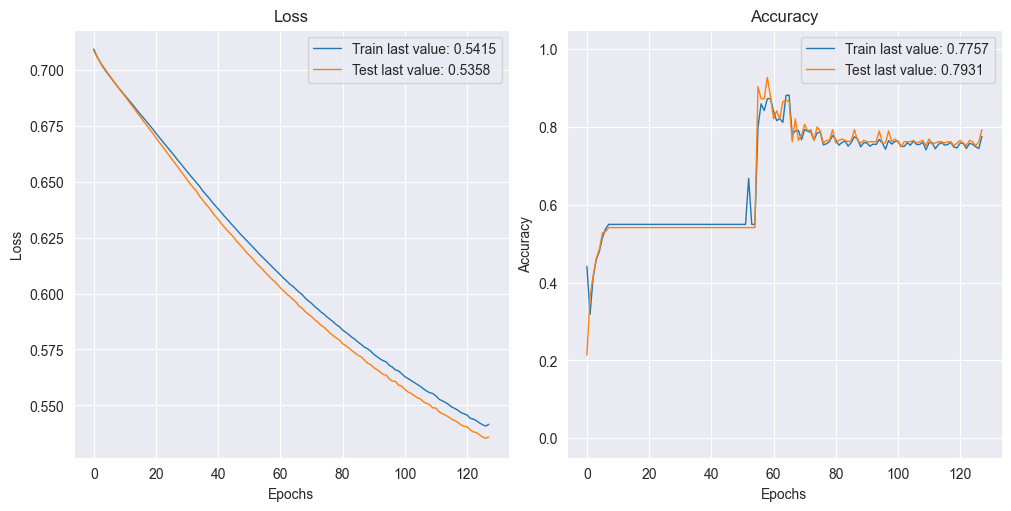

In [23]:
plot_history(results[2],show_standard_deviation=False,show_average=True)
# With Length 150

In [28]:
print(lengths)

[50, 100, 150, 200, 250, 300]


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

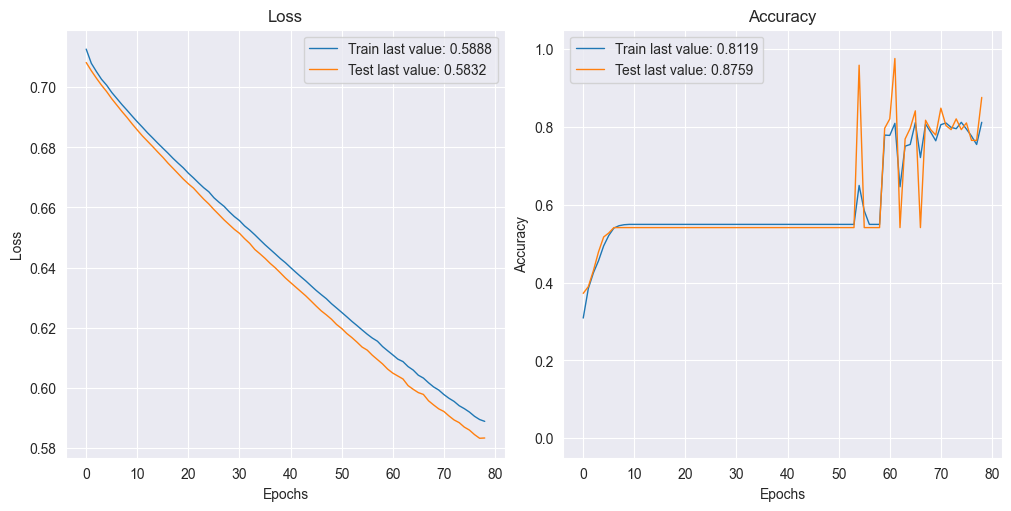

In [24]:
plot_history(results[3],show_standard_deviation=False,show_average=True)
# With Length 200

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

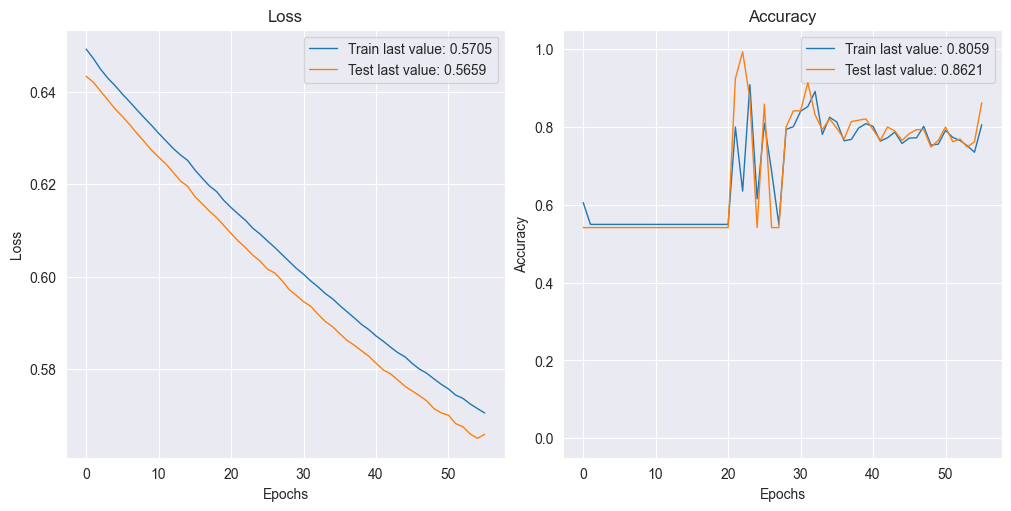

In [25]:
plot_history(results[4],show_standard_deviation=False,show_average=True)
# With Length 250

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

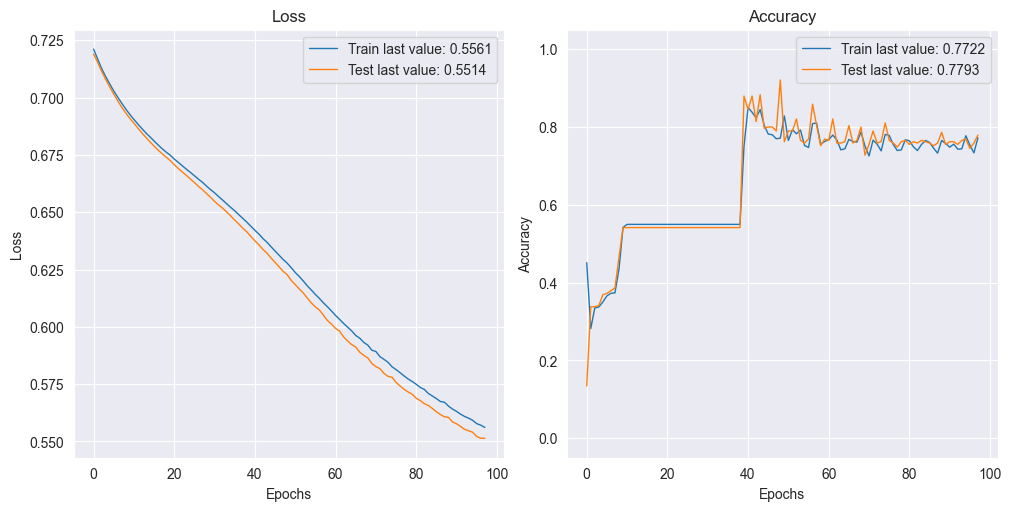

In [26]:
plot_history(results[5],show_standard_deviation=False,show_average=True)
# With Length 300